In [1]:
# run first thing
# !pip install scikeras

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as test_train_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import make_scorer, r2_score
from google.colab import files
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import datetime as dt

In [3]:
# uncomment and run if files are not uploaded
uploaded = files.upload()

In [4]:
class R2Callback(Callback):
    def __init__(self, X_train, y_train, patience=5, restore_best_weights=False,verbose=1):
        super(R2Callback, self).__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.patience = patience
        self.best_r2 = -float('inf')  # Initialize best R^2 score
        self.verbose=verbose
        self.wait = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.X_train)
        r2 = r2_score(self.y_train, y_pred)
        if self.verbose>0:
          print(f"Epoch {epoch+1}, R^2: {r2}")

        # Check if current R^2 score is greater than the best R^2 score
        if r2 > self.best_r2:
            self.best_r2 = r2
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()  # Save the best weights
        else:
            self.wait += 1  # Increment the counter

            # Check if we have reached the patience limit
            if self.wait >= self.patience:
                print(f"Stopping training as R^2 score hasn't improved for {self.patience} epochs.")
                if self.restore_best_weights:
                    print("Restoring best weights...")
                    self.model.set_weights(self.best_weights)  # Restore the best weights
                self.model.stop_training = True

    def reset(self):
        self.best_r2 = -float('inf')
        self.wait = 0
        self.best_weights = None

In [5]:
# Custom R^2 scorer
def r2_scorer(y_true, y_pred):
    return r2_score(y_true, y_pred)

# Define LSTM model
def create_model(n_layers=1, neurons=128, activation='relu', return_sequences=True,):
    model = Sequential()
    for _ in range(n_layers):
        model.add(LSTM(neurons, activation='relu', input_shape=(timesteps, features)))
        if return_sequences:
            model.add(LSTM(units=units//2, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [6]:
class CustomEarlyStopping(Callback):
    def __init__(self, monitor='val_loss', value=0.0163, verbose=0, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.patience = patience
        self.wait=0

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            raise ValueError("The monitored metric '{}' is not available.".format(self.monitor))

        if current >= self.value:
            self.wait += 1
            if self.wait>= self.patience:
              if self.verbose > 0:
                print(f"\nValidation loss reached {self.value}, stopping training.")
              self.model.stop_training = True
        else:
            self.wait = 0

In [7]:
def calculate_r_squared(y_true, y_pred):
    """
    Calculate the R^2 score.

    Parameters:
        y_true (array-like): The true values.
        y_pred (array-like): The predicted values.

    Returns:
        float: R^2 score.
    """
    y_true_mean = np.mean(y_true)
    ss_tot = np.sum((y_true - y_true_mean) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [8]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [9]:
df=pd.read_csv('/content/data_texas_property_zhvi_and_storm_damage_2000-2023.csv')
df.head()

,MONTH,ZHVI,DAMAGE_PROPERTY,EVENT_COUNT
0,2000-01,110404.230186,0.0,76.0
1,2000-02,110464.226696,20889000.0,177.0
2,2000-03,110493.325944,14542700.0,731.0
3,2000-04,110637.748090,17291500.0,616.0
4,2000-05,110731.278136,54610700.0,635.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MONTH            287 non-null    object 
 1   ZHVI             287 non-null    float64
 2   DAMAGE_PROPERTY  287 non-null    float64
 3   EVENT_COUNT      287 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.1+ KB


In [11]:
# convert MONTH to period (m)
df["MONTH"] = df["MONTH"].astype("period[M]")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype    
---  ------           --------------  -----    
 0   MONTH            287 non-null    period[M]
 1   ZHVI             287 non-null    float64  
 2   DAMAGE_PROPERTY  287 non-null    float64  
 3   EVENT_COUNT      287 non-null    float64  
dtypes: float64(3), period[M](1)
memory usage: 9.1 KB


In [12]:

df.sort_values(by=['MONTH'], inplace=True, ascending=True)
df.head()


,MONTH,ZHVI,DAMAGE_PROPERTY,EVENT_COUNT
0,2000-01,110404.230186,0.0,76.0
1,2000-02,110464.226696,20889000.0,177.0
2,2000-03,110493.325944,14542700.0,731.0
3,2000-04,110637.748090,17291500.0,616.0
4,2000-05,110731.278136,54610700.0,635.0


In [13]:
len(df)

287

In [14]:
df['MONTH_YEAR'] = df["MONTH"]

In [15]:
# df['BEGIN_DATE_TIME']=df['BEGIN_DATE_TIME'].astype('datetime64[ns]')

df['MONTH'] = df['MONTH_YEAR'].dt.month
df['YEAR']  = df['MONTH_YEAR'].dt.year
# df['DAY_OF_WEEK']=df['BEGIN_DATE_TIME'].dt.dayofweek
# df['WEEK_OF_YEAR']=df['BEGIN_DATE_TIME'].dt.isocalendar().week

months_list = df['MONTH'].values
# qtr refers to number of months in a quarter out of 12 (which is the cycle of Months in a year)
qtr = 3
df["MONTH_QTR_SIN"] = np.sin(months_list * (2 * np.pi / qtr)).round(4)
df["MONTH_QTR_COS"] = np.cos(months_list * (2 * np.pi / qtr)).round(4)


df.head(12)

,MONTH,ZHVI,DAMAGE_PROPERTY,EVENT_COUNT,MONTH_YEAR,YEAR,MONTH_QTR_SIN,MONTH_QTR_COS
0,1,110404.230186,0.0,76.0,2000-01,2000,0.866,-0.5
1,2,110464.226696,20889000.0,177.0,2000-02,2000,-0.866,-0.5
2,3,110493.325944,14542700.0,731.0,2000-03,2000,-0.000,1.0
3,4,110637.748090,17291500.0,616.0,2000-04,2000,0.866,-0.5
4,5,110731.278136,54610700.0,635.0,2000-05,2000,-0.866,-0.5
5,6,110836.148087,12564000.0,341.0,2000-06,2000,-0.000,1.0
6,7,110905.063871,1749000.0,226.0,2000-07,2000,0.866,-0.5
7,8,111108.943839,1920000.0,327.0,2000-08,2000,-0.866,-0.5
8,9,111376.302312,2694000.0,322.0,2000-09,2000,-0.000,1.0
9,10,111662.782055,3487500.0,241.0,2000-10,2000,0.866,-0.5


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 0 to 286
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype    
---  ------           --------------  -----    
 0   MONTH            287 non-null    int64    
 1   ZHVI             287 non-null    float64  
 2   DAMAGE_PROPERTY  287 non-null    float64  
 3   EVENT_COUNT      287 non-null    float64  
 4   MONTH_YEAR       287 non-null    period[M]
 5   YEAR             287 non-null    int64    
 6   MONTH_QTR_SIN    287 non-null    float64  
 7   MONTH_QTR_COS    287 non-null    float64  
dtypes: float64(5), int64(2), period[M](1)
memory usage: 20.2 KB


In [17]:
df.columns

Index(['MONTH', 'ZHVI', 'DAMAGE_PROPERTY', 'EVENT_COUNT', 'MONTH_YEAR', 'YEAR',
       'MONTH_QTR_SIN', 'MONTH_QTR_COS'],
      dtype='object')

In [30]:
X=df.drop(columns=['ZHVI', 'MONTH_YEAR', "MONTH"])
y=df[['ZHVI']]

In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Normalize the target
scaler_y = MinMaxScaler(feature_range=(0, 1))
# y_normalized =pd.DataFrame(scaler_y.fit_transform(y.reshape(-1,1)), columns=y.columns)
y_reshaped=y.values.reshape(-1,1)
y_normalized =pd.DataFrame(scaler_y.fit_transform(y_reshaped), columns=y.columns)

In [32]:
train_size = int(len(X_normalized) * 0.8)
test_size = len(X_normalized) - train_size


In [33]:
time_steps = 6
X_train, y_train = create_sequences(X_normalized.iloc[0:train_size], y_normalized.iloc[0:train_size], time_steps)
X_test, y_test = create_sequences(X_normalized.iloc[train_size:len(X_normalized)], y_normalized.iloc[train_size:len(X_normalized)], time_steps)

In [34]:
model = Sequential()
model.add(LSTM(256,return_sequences=True))
tf.keras.layers.Dropout(0.2)
model.add(LSTM(256,return_sequences=True))
tf.keras.layers.Dropout(0.2)
model.add(LSTM(256))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [35]:
best_model = None
best_r2 = float(0)
r2_callback = R2Callback(X_test, y_test, patience=15, restore_best_weights=True, verbose=0)

In [36]:
model.fit(X_train, y_train, epochs=1000, verbose=0,callbacks=[r2_callback])
r_squared=calculate_r_squared(y_test, model.predict(X_test))
print("R^2 value:",r_squared)
if r_squared > best_r2:
    best_r2 = r_squared
    best_model = model

2/2 [==============================] - 0s 31ms/step
Stopping training as R^2 score hasn't improved for 15 epochs.
Restoring best weights...
2/2 [==============================] - 0s 26ms/step
R^2 value: 0.733690966922004


In [37]:
def create_lstm_model(n_layers, n_neurons, n_timesteps, n_features):
    model = Sequential()
    for i in range(n_layers - 1):
      if i>0:
        model.add(LSTM(n_neurons,return_sequences=True))
        tf.keras.layers.Dropout(0.2)  # For single layer, keep return_sequences=True by default
    model.add(LSTM(n_neurons))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [39]:
param_grid = {
    'n_layers': [2, 3, 4],
    'n_neurons': [24, 32, 48, 64, 128, 160],
    'time_steps': [3, 6, 7, 8]
}

In [40]:

for params in ParameterGrid(param_grid):
    print("Testing parameters:", params)
    X_train, y_train = create_sequences(X_normalized.iloc[0:train_size], y_normalized.iloc[0:train_size], params['time_steps'])
    X_test, y_test = create_sequences(X_normalized.iloc[train_size:len(X_normalized)], y_normalized.iloc[train_size:len(X_normalized)], params['time_steps'])
    model = create_lstm_model(params['n_layers'], params['n_neurons'], params['time_steps'], len(X_normalized.columns))
    r2_callback.reset()
    model.fit(X_train, y_train, epochs=100000, verbose=0,callbacks=[r2_callback])
    r_squared=calculate_r_squared(y_test, model.predict(X_test))
    print("R^2 value:",r_squared)
    if r_squared > best_r2:
        best_r2 = r_squared
        best_model = model
        best_n_layers = params['n_layers']
        best_n_neurons = params['n_neurons']
        best_n_timesteps = params['time_steps']


print(f"Best model parameters:{best_n_layers},{best_n_neurons},{best_n_timesteps}")
print(best_model.summary())

Testing parameters: {'n_layers': 2, 'n_neurons': 24, 'time_steps': 3}
2/2 [==============================] - 0s 7ms/step
Stopping training as R^2 score hasn't improved for 15 epochs.
Restoring best weights...
2/2 [==============================] - 0s 6ms/step
R^2 value: -4.778904404600671
Testing parameters: {'n_layers': 2, 'n_neurons': 24, 'time_steps': 6}
2/2 [==============================] - 0s 7ms/step
Stopping training as R^2 score hasn't improved for 15 epochs.
Restoring best weights...
2/2 [==============================] - 0s 9ms/step
R^2 value: -0.328825134585671
Testing parameters: {'n_layers': 2, 'n_neurons': 24, 'time_steps': 7}
2/2 [==============================] - 0s 8ms/step
Stopping training as R^2 score hasn't improved for 15 epochs.
Restoring best weights...
2/2 [==============================] - 0s 8ms/step
R^2 value: 0.31803105030661316
Testing parameters: {'n_layers': 2, 'n_neurons': 24, 'time_steps': 8}
2/2 [==============================] - 0s 6ms/step
Stopping

In [41]:
best_model.summary()
print(f"Best model parameters: {best_n_layers} layers, {best_n_neurons} neurons, {best_n_timesteps} time steps")
print(f"Best R^2: {best_r2}")

Model: "sequential_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_285 (LSTM)             (None, 6, 64)             17920     
                                                                 
 lstm_286 (LSTM)             (None, 6, 64)             33024     
                                                                 
 lstm_287 (LSTM)             (None, 64)                33024     
                                                                 
 dense_147 (Dense)           (None, 1)                 65        
                                                                 
Total params: 84033 (328.25 KB)
Trainable params: 84033 (328.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Best model parameters: 4 layers, 64 neurons, 6 time steps
Best R^2: 0.8929856223380976


In [42]:
best_model.save_weights(f"best_model_{dt.datetime.now()}.h5")

In [43]:
best_model.weights

[<tf.Variable 'lstm_285/lstm_cell/kernel:0' shape=(5, 256) dtype=float32, numpy=
 array([[ 0.0766219 , -0.0362162 ,  0.09577394, ..., -0.0087274 ,
          0.00458562,  0.02187587],
        [-0.03411669,  0.08351254,  0.01312475, ...,  0.03177477,
          0.11337621,  0.05165544],
        [-0.06824336, -0.02789782,  0.07170757, ...,  0.03323258,
          0.10289176,  0.24180694],
        [-0.04990684, -0.12615898,  0.08329957, ...,  0.01684541,
          0.15232614,  0.16618235],
        [ 0.13187347, -0.04884759, -0.05262193, ...,  0.09157922,
          0.01774134, -0.05238098]], dtype=float32)>,
 <tf.Variable 'lstm_285/lstm_cell/recurrent_kernel:0' shape=(64, 256) dtype=float32, numpy=
 array([[ 0.11470873,  0.10266887, -0.02412284, ...,  0.04647169,
          0.01897083,  0.06420179],
        [ 0.08259534, -0.04536478,  0.02243355, ...,  0.01983948,
          0.11541681,  0.02677078],
        [-0.017116  ,  0.03279568,  0.05372686, ..., -0.02258151,
         -0.0386051 ,  0.0048

In [45]:
y_prediction = best_model.predict(X_train)
y_prediction

7/7 [==============================] - 4s 6ms/step


array([[0.04249047],
       [0.0425225 ],
       [0.04775472],
       [0.04366701],
       [0.04210918],
       [0.04644968],
       [0.04367978],
       [0.04420549],
       [0.05045294],
       [0.04859546],
       [0.05006683],
       [0.05755306],
       [0.05658444],
       [0.05623647],
       [0.06158563],
       [0.05822104],
       [0.05692171],
       [0.06093049],
       [0.05688348],
       [0.05751811],
       [0.06409442],
       [0.06192689],
       [0.06247253],
       [0.06964625],
       [0.06841205],
       [0.06796015],
       [0.07427767],
       [0.07094555],
       [0.06965923],
       [0.0745053 ],
       [0.07134967],
       [0.07122063],
       [0.07818802],
       [0.07609471],
       [0.07607081],
       [0.08407789],
       [0.08238246],
       [0.08179884],
       [0.08841462],
       [0.08546983],
       [0.08385751],
       [0.08988148],
       [0.08578803],
       [0.08569698],
       [0.09286626],
       [0.09033968],
       [0.08996344],
       [0.098

In [46]:
X_train

array([[[0.00000000e+00, 2.85714286e-02, 0.00000000e+00, 1.00000000e+00,
         0.00000000e+00],
        [4.08150501e-04, 8.62857143e-02, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [2.84150045e-04, 4.02857143e-01, 0.00000000e+00, 5.00000000e-01,
         1.00000000e+00],
        ...,
        [2.45488195e-04, 1.80000000e-01, 0.00000000e+00, 5.00000000e-01,
         1.00000000e+00],
        [3.41737386e-05, 1.14285714e-01, 0.00000000e+00, 1.00000000e+00,
         0.00000000e+00],
        [3.75149103e-05, 1.72000000e-01, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00]],

       [[4.08150501e-04, 8.62857143e-02, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [2.84150045e-04, 4.02857143e-01, 0.00000000e+00, 5.00000000e-01,
         1.00000000e+00],
        [3.37858892e-04, 3.37142857e-01, 0.00000000e+00, 1.00000000e+00,
         0.00000000e+00],
        ...,
        [3.41737386e-05, 1.14285714e-01, 0.00000000e+00, 1.00000000e+00,
        

In [47]:
range(len(X_train))

range(0, 221)

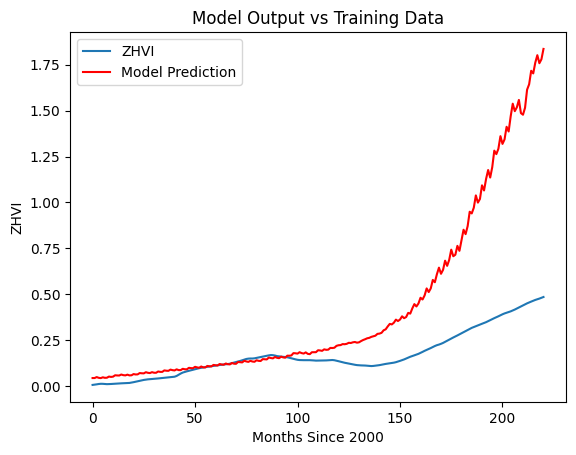

In [49]:
plt.plot(range(len(X_train)), y_train, label="ZHVI")
plt.plot(range(len(X_train)), y_prediction, color="red", label="Model Prediction")
plt.xlabel("Months Since 2000")
plt.ylabel("ZHVI")
plt.title("Model Output vs Training Data")
plt.legend()
plt.show()

I don't know if that looks right based on the supposed R^2 of 0.89